# Summary of ImageNet/ResNet50 Training on a Node

In [1]:
%matplotlib inline
import glob
import json
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('precision', 3)
pd.set_option('display.max_columns', 30)

project_dir = os.getcwd()
dir_anode_single = f'{project_dir}/anode_single'
dir_vnode_single = f'{project_dir}/vnode_single'

In [2]:
# function definitions

def read_data_from_files(file_pattern, name=None):
    ngpus = [1, 4, 8]
    data = []
    for ngpu in ngpus:
        file_pattern0 = file_pattern.format(ngpu=ngpu)
        files = glob.glob(file_pattern0)
        if not files:
            continue
        with open(files[0]) as inf:
            lines = inf.readlines()
            last_line = lines[-1].strip()
            record_str = last_line.split(' ', 1)[1]
            record = json.loads(record_str)
            value = record['data']['train.compute_ips']
            data.append(value)
    return pd.Series(data=data, index=ngpus[:len(data)], name=name)

def load_data():
    node_types = {
        'anode': dir_anode_single,
        'vnode': dir_vnode_single
    }
    methods = {
        'fp32': '',
        'amp': '.amp',
    }

    series = []
    for node, dirpath in node_types.items():
        for method, suffix in methods.items():
            column_key = f'{node}:{method}'
            file_pattern = f'{dirpath}/job_gpu' + '{ngpu}' + f'.sh.*.result{suffix}.json'
            data = read_data_from_files(file_pattern, column_key)
            series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, title, legend_fontsize=None):
    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('# of GPUs')
    ax.set_ylabel('Image/s')

    data0.dropna(how='all').plot.bar(ax=ax, rot=0)
    ax.legend(fontsize=legend_fontsize)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)

In [3]:
data = load_data()
data

,anode:fp32,anode:amp,vnode:fp32,vnode:amp
1,771.917,1249.378,362.116,789.68
4,3054.616,4911.546,1434.770,3092.22
8,6103.385,9448.272,NaN,NaN


## Performance Ratio

In [4]:
data_ratio = {
    'fp32:a100_over_v100': data['anode:fp32'] / data['vnode:fp32'],
    'amp:a100_over_v100': data['anode:amp'] / data['vnode:amp'],
    'a100:amp_over_tf32': data['anode:amp'] / data['anode:fp32'],
    'v100:amp_over_fp32': data['vnode:amp'] / data['vnode:fp32'],
}
pd.DataFrame(data=data_ratio)

,fp32:a100_over_v100,amp:a100_over_v100,a100:amp_over_tf32,v100:amp_over_fp32
1,2.132,1.582,1.619,2.181
4,2.129,1.588,1.608,2.155
8,NaN,NaN,1.548,NaN


## A100 vs. V100

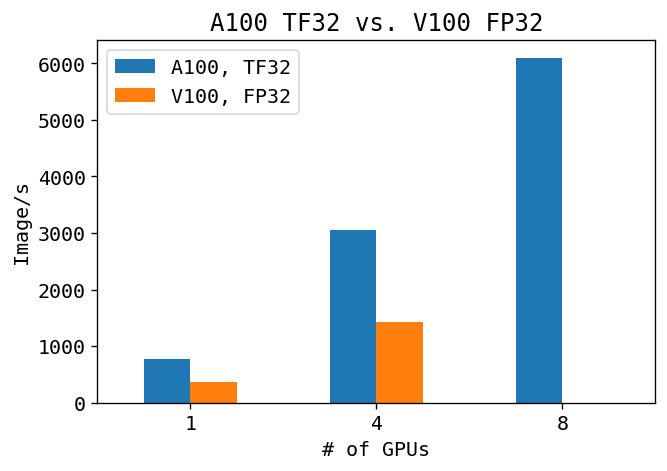

In [5]:
title = 'A100 TF32 vs. V100 FP32'
column_labels = {
    'anode:fp32': 'A100, TF32',
    'vnode:fp32': 'V100, FP32',
}
plot(data, column_labels, title)

## A100: TF32 vs. AMP

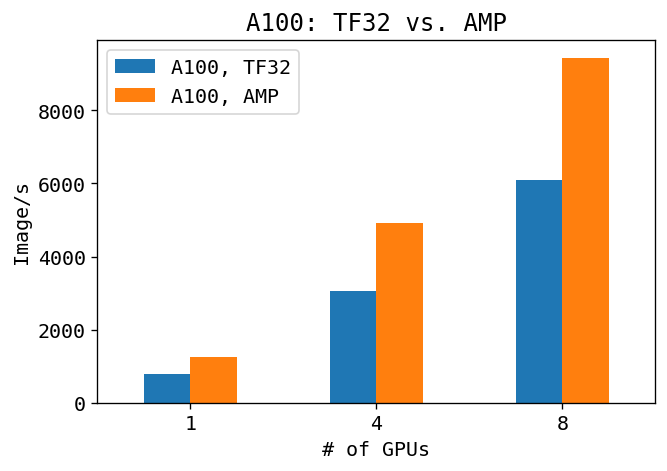

In [6]:
title = 'A100: TF32 vs. AMP'
column_labels = {
    'anode:fp32': 'A100, TF32',
    'anode:amp': 'A100, AMP',
}
plot(data, column_labels, title)

## V100: FP32 vs. AMP

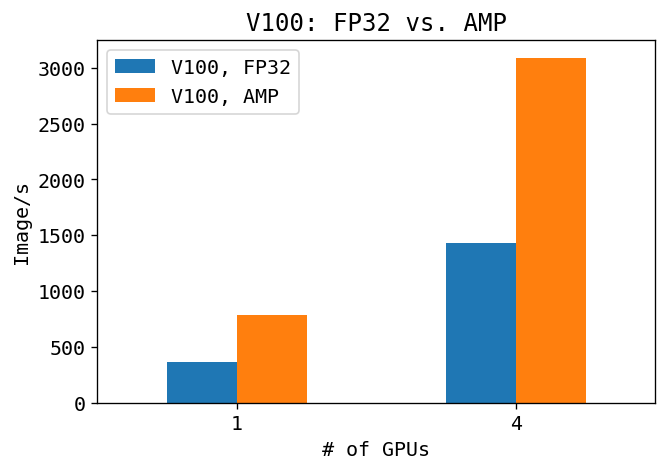

In [7]:
title = 'V100: FP32 vs. AMP'
column_labels = {
    'vnode:fp32': 'V100, FP32',
    'vnode:amp': 'V100, AMP',
}
plot(data, column_labels, title)